In [1]:
import multiprocessing as mp
import os
from collections import defaultdict, Counter

import pandas as pd
from Bio import SeqIO
from magna.gunc import read_contig_assignments_tsv
from tqdm import tqdm

from workflow.config import DEBUG, DIR_OUT_MARKER, R207_MARKERS, PCT_VALUES, R207_BAC120_HMM
from workflow.external.gtdb_metadata import GtdbMetadataR207
from workflow.gunc.aggregate_max_css_level_merged import AggregateMaxCssLevelMerged
from workflow.marker.get_markers_on_contigs_for_failed import GetMarkersOnContigsForFailed
from workflow.method.contig_removal import get_taxonomy_by_majority_vote_gunc, contigs_to_remove_from_gunc
from workflow.method.get_marker_hits_for_gid import get_marker_hits_for_gid
from workflow.model.luigi import LuigiTask, LocalTargetHdf5
from workflow.model.tophit import TopHitPfamFile, TopHitTigrFile
from workflow.util.fasta import read_fasta
from workflow.util.log import log
from workflow.util.paths import get_gid_root
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
DF_META = GtdbMetadataR207().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,gtdb_type_species_of_genus,ncbi_taxonomy,ncbi_taxonomy_unfiltered,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,d__Bacteria;x__Terrabacteria group;p__Firmicut...,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,t,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,t,d__Archaea;p__Nanoarchaeota;c__;o__Nanoarchaea...,d__Archaea;x__DPANN group;p__Nanoarchaeota;o__...,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


In [3]:
DF_CSS = AggregateMaxCssLevelMerged().output().read_cached()
DF_CSS.head()

,n_genes_called,n_genes_mapped,n_contigs,taxonomic_level,proportion_genes_retained_in_major_clades,genes_retained_index,clade_separation_score,contamination_portion,n_effective_surplus_clades,mean_hit_identity,reference_representation_score,pass.GUNC,source
gid,,,,,,,,,,,,,
GCA_000143435.1,2189,2110,4,genus,0.89,0.86,0.55,0.03,0.06,0.95,0.82,False,gtdb
GCA_000153745.1,2202,2165,2,family,0.92,0.90,0.49,0.06,0.12,0.67,0.61,False,progenomes
GCA_000155005.1,6879,6313,84,genus,0.87,0.79,0.79,0.10,0.22,0.97,0.77,False,gtdb
GCA_000161815.1,4499,4335,8,genus,0.80,0.77,0.50,0.19,0.50,0.95,0.74,False,progenomes
GCA_000166735.2,3414,3247,793,genus,0.94,0.90,0.57,0.02,0.05,0.93,0.83,False,progenomes


In [4]:
DF_MERGED = DF_META.merge(DF_CSS, left_index=True, right_index=True)
DF_MERGED.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,taxonomic_level,proportion_genes_retained_in_major_clades,genes_retained_index,clade_separation_score,contamination_portion,n_effective_surplus_clades,mean_hit_identity,reference_representation_score,pass.GUNC,source
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000143435.1,2503,99.48,0.52,350,o__Lactobacillales (UID374),191,0.00,1846395,86.436129,4,...,genus,0.89,0.86,0.55,0.03,0.06,0.95,0.82,False,gtdb
GCA_000153745.1,0,94.58,3.48,615,f__Rhodobacteraceae (UID3356),329,0.00,2113867,92.035190,14,...,family,0.92,0.90,0.49,0.06,0.12,0.67,0.61,False,progenomes
GCA_000155005.1,0,98.81,8.44,1171,f__Enterobacteriaceae (UID5124),335,62.64,5486928,72.322300,364,...,genus,0.87,0.79,0.79,0.10,0.22,0.97,0.77,False,gtdb
GCA_000161815.1,0,99.08,0.18,625,f__Rhodobacteraceae (UID3375),283,0.00,4116223,87.783094,129,...,genus,0.80,0.77,0.50,0.19,0.50,0.95,0.74,False,progenomes
GCA_000166735.2,33,95.81,6.07,443,f__Leuconostocaceae (UID486),178,45.83,1936773,84.277582,893,...,genus,0.94,0.90,0.57,0.02,0.05,0.93,0.83,False,progenomes


In [5]:
DF_MARKER = GetMarkersOnContigsForFailed().output().read_cached()
DF_MARKER.head()

,gid,pct,PF00380.20,PF00410.20,PF00466.21,PF00687.22,PF00827.18,PF00900.21,PF01000.27,PF01015.19,...,TIGR03670,TIGR03671,TIGR03672,TIGR03673,TIGR03674,TIGR03676,TIGR03680,TIGR03723,TIGR03725,TIGR03953
0,GCA_000143435.1,0,unq,unq,unq,unq,mis,mis,unq,mis,...,mis,mis,mis,mis,mis,mis,mis,unq,unq,unq
1,GCA_000143435.1,1,unq,unq,unq,unq,mis,mis,unq,mis,...,mis,mis,mis,mis,mis,mis,mis,unq,unq,unq
2,GCA_000143435.1,5,unq,unq,unq,unq,mis,mis,unq,mis,...,mis,mis,mis,mis,mis,mis,mis,unq,unq,unq
3,GCA_000143435.1,15,unq,unq,unq,unq,mis,mis,unq,mis,...,mis,mis,mis,mis,mis,mis,mis,unq,unq,unq
4,GCA_000153745.1,0,unq,unq,unq,unq,mis,mis,unq,mis,...,mis,mis,mis,mis,mis,mis,mis,unq,unq,unq


In [6]:
MARKER_FAIL_GIDS = {'GCA_002170165.1', 'GCA_002401495.1', 'GCA_014385135.2', 'GCA_017515185.1', 'GCA_900765805.1', 'GCA_905214645.1'}

In [7]:
def get_gid_to_rows():
    out = defaultdict(dict)
    for _, row in tqdm(DF_MARKER.iterrows(), total=len(DF_MARKER)):
        out[row['gid']][row['pct']] = tuple([row[x] for x in R207_MARKERS])
    return out
GID_TO_ROWS = get_gid_to_rows()

100%|██████████| 312035/312035 [02:51<00:00, 1819.41it/s]


In [8]:
def get_rows_that_differ_from_baseline(gid_to_rows):
    differ_rows = list()

    for gid, d_pct_to_row in tqdm(gid_to_rows.items()):
        first_row = d_pct_to_row[0]
        prev_row = first_row

        for pct in PCT_VALUES:
            cur_row = d_pct_to_row.get(pct, None)

            # Not present, so carry forward the previous value
            if cur_row is None:
                use_row = prev_row

            # Is present, so use the current value
            else:
                use_row = cur_row
                prev_row = use_row

            if use_row != first_row:
                differ_rows.append((gid, pct))
    return differ_rows
ROWS_THAT_DIFFER = get_rows_that_differ_from_baseline(GID_TO_ROWS)

100%|██████████| 35723/35723 [00:00<00:00, 91543.24it/s]


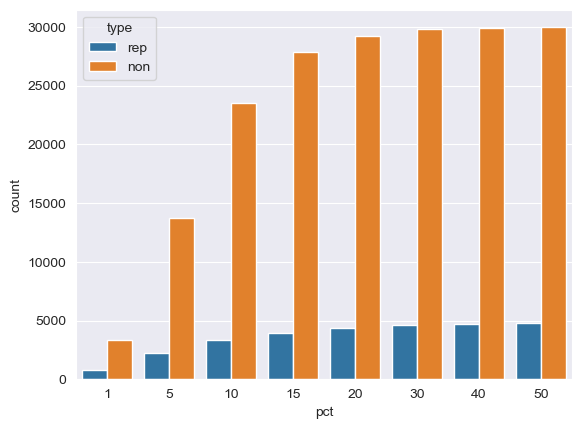

In [9]:
def what_prop_of_differ_are_reps_non_reps():

    rep_gids = set(DF_MERGED[DF_MERGED['gtdb_representative'] == 't'].index)

    d_reps_at_pct = defaultdict(set)
    d_non_at_pct = defaultdict(set)
    for gid, pct in ROWS_THAT_DIFFER:
        if gid in rep_gids:
            d_reps_at_pct[pct].add(gid)
        else:
            d_non_at_pct[pct].add(gid)

    rows = list()
    for pct, set_gids in d_reps_at_pct.items():
        rows.append({
            'pct': pct,
            'type': 'rep',
            'count': len(set_gids)
        })
    for pct, set_gids in d_non_at_pct.items():
        rows.append({
            'pct': pct,
            'type': 'non',
            'count': len(set_gids)
        })

    df = pd.DataFrame(rows)

    sns.barplot(data=df, hue='type', x='pct', y='count')
    # print(f'Number of reps: {len(chg_reps):,}')
    # print(f'Number of non-reps: {len(chg_non_reps):,}')
    # print(f'Total: {len(chg_reps) + len(chg_non_reps):,}')

    return
what_prop_of_differ_are_reps_non_reps()

100%|██████████| 35723/35723 [00:03<00:00, 9526.75it/s] 


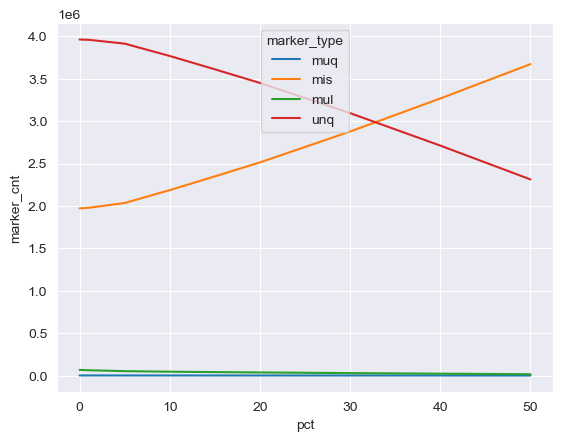

In [10]:
def plot_total_number_of_markers_at_each_pct_value():
    # Note: Carry forward the previous cutoff value data if no further data are present

    d_pct_to_counts = defaultdict(lambda: defaultdict(lambda: 0))

    for gid, d_pct_to_row in tqdm(GID_TO_ROWS.items()):



        prev_count = Counter(d_pct_to_row[0])
        d_pct_to_counts[0]['muq'] += prev_count.get('muq', 0)
        d_pct_to_counts[0]['mis'] += prev_count.get('mis', 0)
        d_pct_to_counts[0]['mul'] += prev_count.get('mul', 0)
        d_pct_to_counts[0]['unq'] += prev_count.get('unq', 0)

        for pct in PCT_VALUES:
            cur_row = d_pct_to_row.get(pct, None)

            # Not present, so carry forward the previous value
            if cur_row is None:
                use_count = prev_count

            # Is present, so use the current value
            else:
                use_count = Counter(cur_row)
                prev_count = use_count

            d_pct_to_counts[pct]['muq'] += use_count.get('muq', 0)
            d_pct_to_counts[pct]['mis'] += use_count.get('mis', 0)
            d_pct_to_counts[pct]['mul'] += use_count.get('mul', 0)
            d_pct_to_counts[pct]['unq'] += use_count.get('unq', 0)

    rows = list()
    for pct, d_cnts in d_pct_to_counts.items():
        for marker_type, marker_cnt in d_cnts.items():
            rows.append({
                'pct': pct,
                'marker_type': marker_type,
                'marker_cnt': marker_cnt,
            })
    df = pd.DataFrame(rows)

    sns.lineplot(x='pct', y='marker_cnt', hue='marker_type', data=df)
plot_total_number_of_markers_at_each_pct_value()

100%|██████████| 35723/35723 [00:00<00:00, 1889089.35it/s]


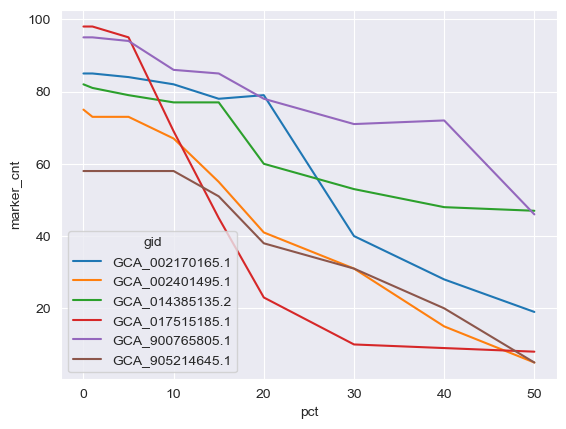

In [13]:
def plot_total_number_of_markers_at_each_pct_value_bw():
    # Note: Carry forward the previous cutoff value data if no further data are present

    d_pct_to_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))


    for gid, d_pct_to_row in tqdm(GID_TO_ROWS.items()):

        if gid not in MARKER_FAIL_GIDS:
            continue

        prev_count = Counter(d_pct_to_row[0])
        d_pct_to_counts[gid][0]['muq'] += prev_count.get('muq', 0)
        d_pct_to_counts[gid][0]['mis'] += prev_count.get('mis', 0)
        d_pct_to_counts[gid][0]['mul'] += prev_count.get('mul', 0)
        d_pct_to_counts[gid][0]['unq'] += prev_count.get('unq', 0)

        for pct in PCT_VALUES:
            cur_row = d_pct_to_row.get(pct, None)

            # Not present, so carry forward the previous value
            if cur_row is None:
                use_count = prev_count

            # Is present, so use the current value
            else:
                use_count = Counter(cur_row)
                prev_count = use_count

            d_pct_to_counts[gid][pct]['muq'] += use_count.get('muq', 0)
            d_pct_to_counts[gid][pct]['mis'] += use_count.get('mis', 0)
            d_pct_to_counts[gid][pct]['mul'] += use_count.get('mul', 0)
            d_pct_to_counts[gid][pct]['unq'] += use_count.get('unq', 0)

    rows = list()
    for gid, d_pcts in d_pct_to_counts.items():
        for pct, d_cnts in d_pcts.items():
            rows.append({
                'gid': gid,
                'pct': pct,
                'marker_cnt': d_cnts['muq'] + d_cnts['unq']  # + d_cnts['mul']
            })
            # for marker_type, marker_cnt in d_cnts.items():
            #     rows.append({
            #         'pct': pct,
            #         'marker_type': marker_type,
            #         'marker_cnt': marker_cnt,
            #     })
    df = pd.DataFrame(rows)
    plt.rcParams['svg.fonttype'] = 'none'
    sns.lineplot(x='pct', y='marker_cnt', hue='gid', data=df)
    plt.savefig("/tmp/explore_markers.svg")
plot_total_number_of_markers_at_each_pct_value_bw()

In [12]:
from workflow.config import R207_AR53_HMM


def report_changes_for_genomes():

    changes = list()
    for gid, d_pct_to_row in tqdm(GID_TO_ROWS.items()):

        if gid != 'GCA_014385135.2':
            continue


        domain = DF_MERGED.loc[gid, 'domain']

        if domain == 'd__Bacteria':
            marker_set = set(R207_BAC120_HMM)
        elif domain == 'd__Archaea':
            marker_set = set(R207_AR53_HMM)
        else:
            raise Exception('unknown domain')

        first_row = d_pct_to_row[0]

        for pct, row in d_pct_to_row.items():

            if pct > 5:
                continue

            if row != first_row:
                for i, (marker, hit) in enumerate(zip(R207_MARKERS, row)):
                    marker_is_in_domain = marker in marker_set
                    expected_val = first_row[i]
                    if hit != expected_val:
                        changes.append(f'{gid} {marker} ({marker_is_in_domain}): {expected_val} -> {hit}')

        if len(changes) > 1000:
            break

    print('\n'.join(changes[0:1000]))

    return

report_changes_for_genomes()


100%|██████████| 35723/35723 [00:00<00:00, 1956148.13it/s]

GCA_014385135.2 PF01025.20 (True): unq -> mis
GCA_014385135.2 PF01025.20 (True): unq -> mis
GCA_014385135.2 TIGR00083 (True): unq -> mis
GCA_014385135.2 TIGR00092 (True): unq -> mis
GCA_014385135.2 TIGR00431 (True): unq -> mis
GCA_014385135.2 TIGR00635 (True): unq -> mis
GCA_014385135.2 TIGR01039 (True): mul -> unq
GCA_014385135.2 TIGR01146 (True): mul -> unq
